In [1]:
#imports
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matminer.featurizers.composition import ElementProperty
from pymatgen import Composition
from camd.agent.base import HypothesisAgent
from camd.analysis import AnalyzerBase
from camd.campaigns.base import Campaign
from camd.experiment.base import ATFSampler
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
import os
from monty.os import cd

## Data Prep

In [2]:
#load jcap data into a data frame
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner

jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))

energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
jcap_df.shape

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:01<00:00, 138MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 22.1kB/s]


(100430, 45)

In [3]:
#define alloy system
Z = ['Ni', 'Mn']

#find all entries that have some amount of elements in Z
jcap_df = jcap_df[jcap_df.loc[:,Z[0]] > 0.0]
jcap_df = jcap_df[jcap_df.loc[:,Z[1]] > 0.0]

#total proportion of Z must be at least cutoff
cutoff = 0.50
jcap_df = jcap_df[jcap_df.loc[:,Z[0]] + jcap_df.loc[:,Z[1]] > 0.5]

#drop vae and spectrum, not used in model
jcap_df = jcap_df.drop('vae', axis=1)
jcap_df = jcap_df.drop('spectrum', axis=1)

#remove any elements that are not represented in data set
drop_list = []
for i in range(2,jcap_df.shape[1]):
    if not (np.any(jcap_df.iloc[:,i])):
        drop_list.append(jcap_df.iloc[:,i].name)
        
print("Dropping these elements from composition: \n", drop_list)
jcap_df = jcap_df.drop(drop_list, axis=1)

Dropping these elements from composition: 
 ['Sn', 'Ti', 'Zn', 'Ce', 'Cu', 'W', 'Mo', 'Cr', 'Y', 'Sr', 'Gd', 'Sb', 'Nb', 'Ga', 'Al', 'Pb', 'Mg', 'Pr', 'Zr', 'Ba', 'P', 'Sc', 'Ag', 'Tb', 'Pd', 'Hf', 'Rb']


In [4]:
#convert composition to a vector, ensure all add to 1
formula = []
for i in range(1,jcap_df.shape[1]):
    formula.append(jcap_df.iloc[:,i].name)

compositions = []
for i in range(jcap_df.shape[0]):
    compositions.append(np.array(jcap_df.iloc[i,1:]))
    
# jcap_df['composition'] = compositions
# jcap_df = jcap_df.drop(formula, axis=1)
jcap_df.head()

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd
comp_id,,,,,,,,,,,,,,,,
13225,2.425327,0.0,0.0,0.50,0.000,0.0,0.15,0.0,0.0,0.35,0.0,0.000,0.0,0.0,0.0,0.0
13226,2.409050,0.0,0.0,0.15,0.045,0.0,0.40,0.0,0.0,0.40,0.0,0.005,0.0,0.0,0.0,0.0
13227,2.302296,0.0,0.0,0.25,0.135,0.0,0.50,0.0,0.0,0.10,0.0,0.015,0.0,0.0,0.0,0.0
13229,2.231123,0.0,0.0,0.15,0.180,0.0,0.60,0.0,0.0,0.05,0.0,0.020,0.0,0.0,0.0,0.0
13230,2.437762,0.0,0.0,0.90,0.000,0.0,0.10,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0.0


In [5]:
#sort by bandgap value
jcap_df = jcap_df.sort_values("bandgap", ascending=True)
jcap_df.head()

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd
comp_id,,,,,,,,,,,,,,,,
93072,0.681642,0.4,0.0,0.5,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93059,0.704428,0.0,0.2,0.2,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93050,0.730551,0.2,0.1,0.4,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93187,0.735384,0.0,0.1,0.3,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93016,0.773443,0.3,0.1,0.4,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#prepare candidate and test datasets
k_seed_data = jcap_df.iloc[::2]
k_candidate_data = jcap_df.iloc[1::2]
# k_candidate_data = k_candidate_data.drop(['bandgap'], axis=1)
k_candidate_data.head()
print(k_seed_data.shape)
print(k_candidate_data.shape)

(2963, 16)
(2963, 16)


In [7]:
assert not set(k_seed_data.index).intersection(k_candidate_data.index)

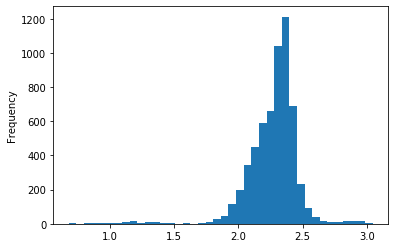

In [8]:
#bandgap histogram
jcap_df['bandgap'].plot.hist(bins=40)

## Agent

In [9]:
def get_composition(dataframe):
    composition = [column for column in dataframe 
                      if len(column) == 2]
    return dataframe[composition]

In [10]:
#define agent
class RandomForestAgent(HypothesisAgent):
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = get_composition(seed_data)
        y_known = seed_data['bandgap']
        regressor = RandomForestRegressor(n_estimators=10)
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown = get_composition(candidate_data)
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates
        candidate_data['bandgap_pred'] = y_predicted
        candidate_data = candidate_data.sort_values(
            'bandgap_pred', ascending=True)
        top_candidates = candidate_data.head(5)
        return top_candidates

In [11]:
#test agent
rf_agent = RandomForestAgent()
hypotheses = rf_agent.get_hypotheses(k_candidate_data, k_seed_data)
hypotheses

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd,bandgap_pred
comp_id,,,,,,,,,,,,,,,,,
92935,0.877384,0.2,0.10,0.50,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.889645
93033,1.017334,0.1,0.30,0.40,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.896111
92933,1.154625,0.4,0.00,0.40,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.908103
93109,0.901216,0.1,0.20,0.50,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.928476
93542,1.911164,0.1,0.35,0.45,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.937307


## Experiment

In [12]:
#define experiment
k_atf_experiment = ATFSampler(dataframe=jcap_df)

In [13]:
k_atf_experiment.submit(hypotheses)
results = k_atf_experiment.get_results()
results

,bandgap,Fe,Co,Ni,Bi,V,Mn,La,Er,Sm,In,Ca,Eu,Lu,Yb,Nd
comp_id,,,,,,,,,,,,,,,,
92935,0.877384,0.2,0.10,0.50,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93033,1.017334,0.1,0.30,0.40,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92933,1.154625,0.4,0.00,0.40,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93109,0.901216,0.1,0.20,0.50,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93542,1.911164,0.1,0.35,0.45,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analyzer

In [14]:
#define analyzer
class BandgapAnalyzer(AnalyzerBase):
    def analyze(self, new_experimental_results, seed_data):
        new_seed = pd.concat(
            [seed_data, new_experimental_results],
        axis=0)
        # Create a summary
        average_new_diff = new_experimental_results.bandgap.median()
        average_dataset_diff = new_seed.bandgap.median()
        new_result_ranks = new_seed.bandgap.rank(pct=True).loc[
            new_experimental_results.index
        ]
        summary = pd.DataFrame({
            "average_new_bandgap": [average_new_diff],
            "average_dataset_bandgap": [average_dataset_diff],
            "average_rank": [new_result_ranks.mean()]
        })
        return summary, new_seed

In [15]:
k_analyzer = BandgapAnalyzer()
summary, new_seed = k_analyzer.analyze(results, k_seed_data)

In [16]:
summary

,average_new_bandgap,average_dataset_bandgap,average_rank
0,1.017334,2.3047,0.009232


In [17]:
#define campaign
# Set up folders
os.system('rm -rf test')
os.system('mkdir -p test')
# Reinitialize experiment to clear history
k_atf_experiment = ATFSampler(dataframe=jcap_df)
with cd('test'):
    campaign = Campaign(
        candidate_data=k_candidate_data, 
        seed_data=k_seed_data,
        agent=rf_agent,
        experiment=k_atf_experiment,
        analyzer=k_analyzer
    )
    campaign.auto_loop(initialize=True)

Campaign initialization state: Agent RandomForestAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RandomForestAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RandomForestAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RandomForestAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RandomForestAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Ca

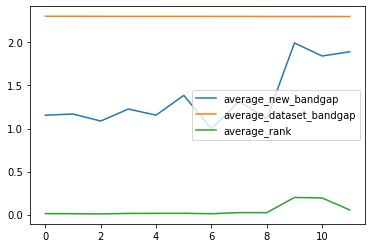

In [18]:
#visualize learning
history = pd.read_pickle('test/history.pickle')
history.plot()

In [19]:
history

,average_new_bandgap,average_dataset_bandgap,average_rank
0,1.154625,2.304700,0.010849
1,1.168237,2.304485,0.009754
2,1.086811,2.303881,0.007388
3,1.226315,2.303564,0.013141
4,1.155207,2.303319,0.013788
5,1.385112,2.303004,0.014567
6,0.996921,2.302872,0.009540
7,1.316169,2.302701,0.022511
8,1.115513,2.302389,0.022074
9,1.994254,2.302192,0.198805


In [20]:
_, result_history = k_atf_experiment.agg_history

Average prediction error:  0.07774388653169863


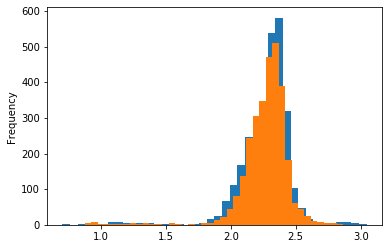

In [21]:
k_candidate_data = k_candidate_data.drop(formula, axis=1)
k_candidate_data['bandgap_err'] = np.abs(k_candidate_data.bandgap - k_candidate_data.bandgap_pred)
k_candidate_data = k_candidate_data.sort_values("bandgap", ascending=True)
print("Average prediction error: ", np.mean(k_candidate_data.bandgap_err))
k_candidate_data['bandgap'].plot.hist(bins=40)
k_candidate_data['bandgap_pred'].plot.hist(bins=40)
# k_candidate_data.style.apply(
#     lambda x: ['background: darkorange' 
#                if (x.name in result_history.index)
#                else '' for i in x], axis=1)

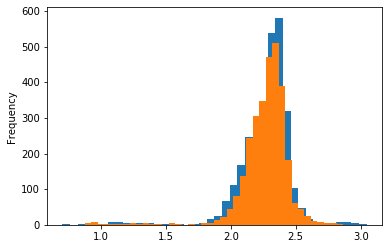

In [22]:
k_candidate_data['bandgap'].plot.hist(bins=40)
k_candidate_data['bandgap_pred'].plot.hist(bins=40)

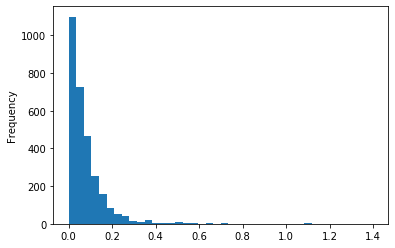

In [23]:
k_candidate_data['bandgap_err'].plot.hist(bins=40)


In [24]:
mean_absolute_error(list(k_candidate_data['bandgap']), list(k_candidate_data['bandgap_pred']))

0.07774388653169863